In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import pandas as pd
import subprocess
from sklearn.model_selection import train_test_split
from pkg.paratsne.parametric_tsne import ParametricTSNE
from scipy.stats import boxcox
from sklearn.preprocessing import KBinsDiscretizer
#import keras_ocr
import src.tools as tools
import seaborn as sns
from tqdm import tqdm
import json
from datetime import date
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
#check csv file
stations = ['ParkersBrook','BrownsBrook','GrantPoole']
station_name = stations[2]
outfile = f'/datadrive/stream_data/training/{station_name}/{station_name}_table.csv'
df = pd.read_csv(outfile)

In [16]:
#X = np.array([np.array(Image.open(im['FILENAME'])) for _,im in df.iterrows()])
#transformer = ParametricTSNE()
#X_new = transformer.fit_transform(X)

In [3]:
#categorical variable is wrong
#use the percentiles to determine thresholds dynamically
log_discharge = np.array(boxcox(df['DISCHARGE'],0))
df['LOG_DISCHARGE']=log_discharge

#percentiles = [2.5, 25, 75, 95]
#thr = {}
#for p in percentiles:
#    thr[f'pct_{p}'] = np.percentile(log_discharge,p)
#print(thr)

n_classes = 5
kbins = KBinsDiscretizer(n_bins=n_classes,encode='ordinal',strategy='uniform')
data_trans = kbins.fit_transform(np.array([log_discharge]).T).astype(int)
edges = kbins.bin_edges_[0]
unique, counts = np.unique(data_trans, return_counts=True)
df['KBIN'] = data_trans

In [7]:
df['DATETIME'][:20]

0     2019-10-18 11:00:00
1     2019-10-18 12:00:00
2     2019-10-18 13:00:00
3     2019-10-18 14:00:00
4     2019-10-18 15:00:00
5     2019-10-18 16:00:00
6     2019-10-19 10:00:00
7     2019-10-19 11:00:00
8     2019-10-19 12:00:00
9     2019-10-19 13:00:00
10    2019-10-19 14:00:00
11    2019-10-19 15:00:00
12    2019-10-19 16:00:00
13    2019-10-20 10:00:00
14    2019-10-20 11:00:00
15    2019-10-20 12:00:00
16    2019-10-20 13:00:00
17    2019-10-20 14:00:00
18    2019-10-20 15:00:00
19    2019-10-20 16:00:00
Name: DATETIME, dtype: object

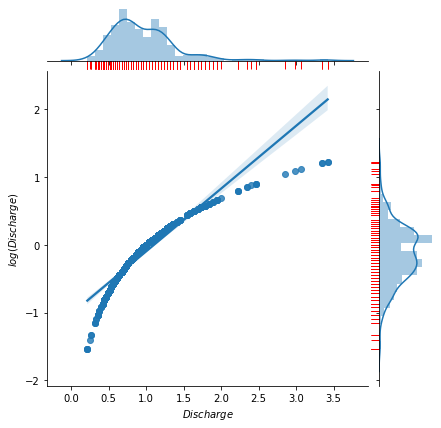

In [8]:
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})
h = sns.jointplot(df['DISCHARGE'], log_discharge, kind='reg')
h.set_axis_labels('$Discharge$', '$log(Discharge)$')
h.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

<AxesSubplot:xlabel='DATETIME'>

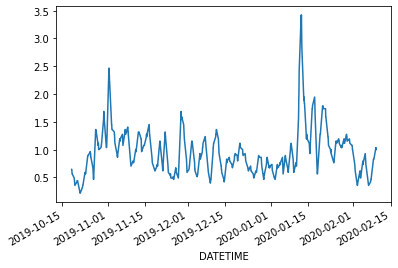

In [24]:
df['DISCHARGE'].plot()

<AxesSubplot:xlabel='DATETIME'>

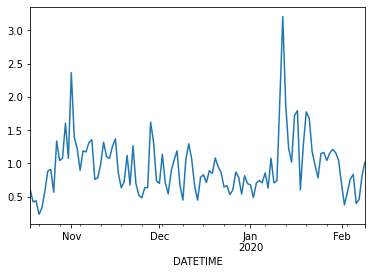

In [23]:
#what does discharge look like for a daily rate?
df.resample('D').mean()['DISCHARGE'].plot()
#it really seems like it might be fine to sample hourly....?

In [32]:
df.head()

,INDEX,FILENAME,DATETIME,DISCHARGE,ZSCORE,CATEGORY,FILENAME_RAW,LOG_DISCHARGE,KBIN
DATETIME,,,,,,,,,
2019-10-18 11:00:00,0,/datadrive/stream_data/GrantPoole/PICT0001.JPG,2019-10-18 11:00:00,0.645,-0.720901,0,PICT0001.JPG,-0.438505,1
2019-10-18 12:00:00,1,/datadrive/stream_data/GrantPoole/PICT0002.JPG,2019-10-18 12:00:00,0.645,-0.720901,0,PICT0002.JPG,-0.438505,1
2019-10-18 13:00:00,2,/datadrive/stream_data/GrantPoole/PICT0003.JPG,2019-10-18 13:00:00,0.617,-0.786780,0,PICT0003.JPG,-0.482886,1
2019-10-18 14:00:00,3,/datadrive/stream_data/GrantPoole/PICT0004.JPG,2019-10-18 14:00:00,0.590,-0.850307,0,PICT0004.JPG,-0.527633,1
2019-10-18 15:00:00,4,/datadrive/stream_data/GrantPoole/PICT0005.JPG,2019-10-18 15:00:00,0.563,-0.913833,0,PICT0005.JPG,-0.574476,1


In [36]:
test = df[['FILENAME','DISCHARGE']].head(6)

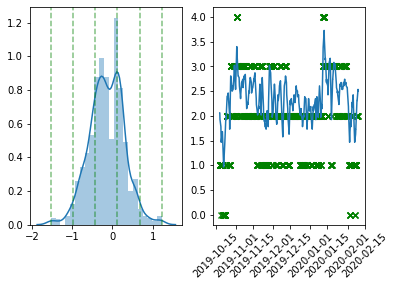

In [25]:
t = df['DATETIME'].astype(np.datetime64)
f, ax = plt.subplots(1,2)
sns.distplot(log_discharge, ax=ax[0])
#for _,t in thr.items():
#    ax.axvline(t,0,0.9,color='red',ls='--',alpha=0.5)
for edge in edges:
    ax[0].axvline(edge, color='green',ls='--',alpha=0.5)
    
ax[1].scatter(t,data_trans.T[0], color='green', marker='x',alpha=0.9)
adj = 2.5
ax[1].plot(t,log_discharge+adj)
ax[1].tick_params(axis='x', rotation=45)

In [ ]:
#perhaps if we considered daily flow that would better to use for regression estimates
#a long series of images might indicate a consistant flow 

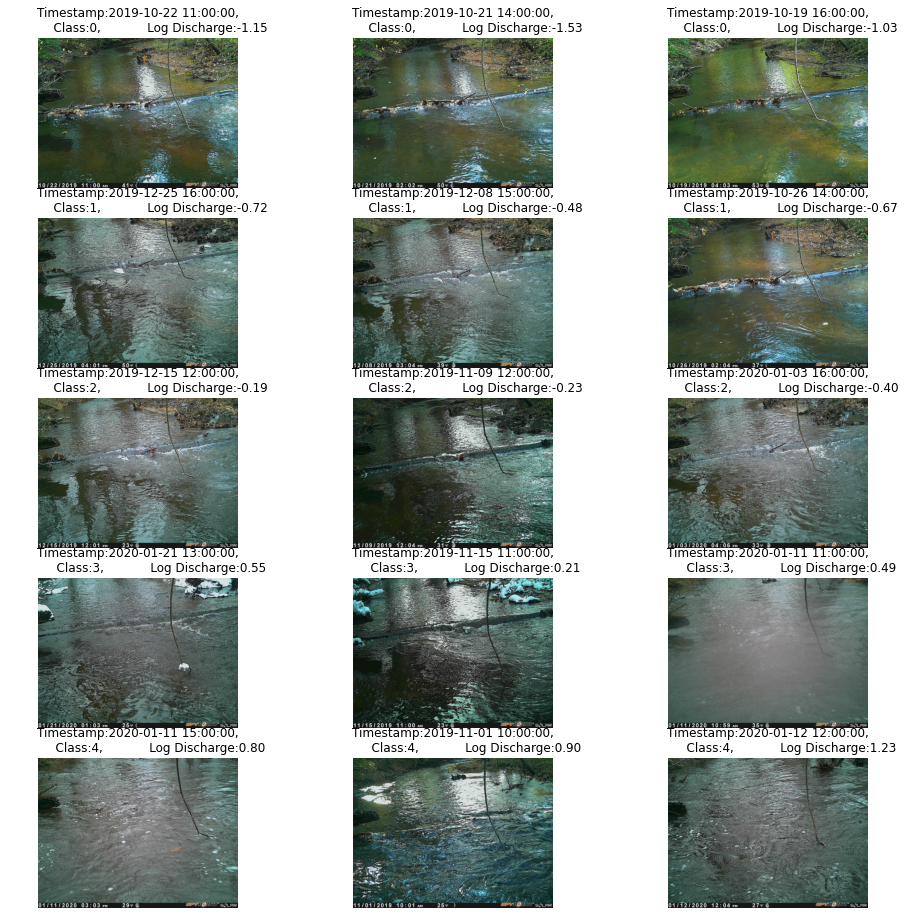

In [82]:
f, ax = plt.subplots(5,3,figsize=(16,16))
samples = 3
for c in range(n_classes):
    batch = df[df['KBIN']==c].sample(n=samples)
    for i,(_,b) in enumerate(batch.iterrows()):
        im = Image.open(b['FILENAME'])
        ax[c,i].imshow(im)
        ax[c,i].axis('off')
        ax[c,i].set_title(f"Timestamp:{b['DATETIME']},\n\
            Class:{b['KBIN']:d},\
            Log Discharge:{b['LOG_DISCHARGE']:0.2f}")

In [83]:
#now write them over again and use the image resize
wd = f'/datadrive/stream_data/training/{station_name}'
#read filenames
split_ratio = 0.3
seed = 1337 
tables = tools.create_data_splits(df,split_ratio=split_ratio,seed=seed) 
#divide the data into training validation test
bins = ['train', 'val', 'test']
for b in bins:
    path = f'{wd}/{b}'
    if not os.path.exists(path):
        os.mkdir(path)
    NEW_R,NEW_C = 640,480
    new_shape = (NEW_R, NEW_C)
    filelist = []
    for ref_im,name in tqdm(zip(tables[b]['FILENAME'], tables[b]['FILENAME_RAW'])):
        new_filename = f'{path}/{name.lower()}'
        #resize and save image in int format
        #write these files but only after path has been assigned 
        rz_im = tools.image_resize(Image.open(ref_im), shape=new_shape).save(new_filename)
        filelist.append(new_filename)
    tables[b]['FILENAME'] = filelist
    outtable = tables[b].copy()[['INDEX', 'DATETIME', 'DISCHARGE',\
                                 'LOG_DISCHARGE','ZSCORE','KBIN']]
    outtable['FILENAME'] = filelist
    outtable_name = f'{wd}/{b}_table.csv'
    outtable.to_csv(outtable_name, header=True, index=False)

559it [01:05,  8.54it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
120it [00:14,  8.55it/s]
120it [00:13,  8.57it/s]


In [91]:
########################BREAK#######################